<a href="https://colab.research.google.com/github/Betsabeh/Python_codes-tutorial-/blob/main/Deep_Convolutional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LeakyReLU
import numpy as np
import matplotlib.pyplot as plt


In [15]:
# define the Generator model
def build_Generator(latent_input: input):
  model = tf.keras.models.Sequential()
  # Dense layer
  model.add(tf.keras.layers.Dense(7*7*256,use_bias= False,input_shape=latent_input.shape[1:]))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(LeakyReLU())
  model.add(tf.keras.layers.Reshape((7,7,256)))
  #Conv2D
  model.add(tf.keras.layers.Conv2DTranspose(filters=128,kernel_size=(5,5),strides =(1,1),
                                            padding='same', use_bias= False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  #Conv2D reduced the volume
  model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5),strides =(2,2),
                                            padding='same', use_bias= False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  #final Conv2D
  model.add(tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(5,5),strides =(2,2),
                                            padding='same', use_bias= False, activation='tanh'))

  # forward step
  generated = model (latent_input)
  return Model(z, generated)


In [19]:
# define the Discriminator model
def build_Discriminator():
  model = tf.keras.models.Sequential()
  #first conv2D
  model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=(5,5), strides =(2,2),
                                   padding = 'same', input_shape =(28,28,1)))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  #second Conv2d
  model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=(5,5), strides =(2,2),
                                   padding = 'same', input_shape =(28,28,1)))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  #flatten
  model.add(tf.keras.layers.Flatten())
  #dense
  model.add(tf.keras.layers.Dense(1, activation= 'sigmoid'))

  image = Input(shape =(28,28,1))
  output = model(image)

  return Model(image, output)



In [24]:
#train model
def train(generator, discriminator,combined,steps, batch_size):
   #load data
   (x_train,_),_ =mnist.load_data()
   # Rescale in [-1, 1] interval
   x_train = (x_train.astype(np.float32) - 127.5) / 127.5
   x_train = np.expand_dims(x_train, axis=-1)

   #discriminator label
   real = np.ones((batch_size, 1))
   fake = np.zeros((batch_size, 1))

   latent_dim = generator.input_shape[1]

   for step in range(steps):
    real_images = x_train[np.random.randint(0, x_train.shape[0],batch_size)]
    # Random batch of noise
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    # Generate a batch of new images
    generated_images = generator.predict(noise)

    # Train the discriminator
    discriminator_real_loss = discriminator.train_on_batch(real_images, real)
    discriminator_fake_loss = discriminator.train_on_batch(generated_images, fake)
    discriminator_loss = 0.5 * np.add(discriminator_real_loss,discriminator_fake_loss)

    # Train the generator
    # random latent vector z
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generator_loss = combined.train_on_batch(noise, real)

    print("%d [Discriminator loss: %.4f%%, acc.: %.2f%%] [Generatorloss: %.4f%%]" % (step, discriminator_loss[0], 100 * discriminator_loss[1], generator_loss))


In [7]:
def plot_generated_image(generator):
  n=10
  digit_size =28
  #big array of images
  Image = np.zeros((digit_size * n, digit_size * n))

  latent_dim = generator.input_shape[1]
  # n*n random latent distributions
  noise = np.random.normal(0, 1, (n * n, latent_dim))
  generated_images = generator.predict(noise)

  for i in range(n):
    for j in range(n):
       slice_i = slice(i * digit_size, (i + 1) * digit_size)
       slice_j = slice(j * digit_size, (j + 1) * digit_size)
       Image[slice_i, slice_j] = np.reshape(generated_images[i * n + j], (28, 28))



  #plot
  plt.figure(figsize=(6, 5))
  plt.axis('off')
  plt.imshow(Image, cmap='Greys_r')
  plt.show()

Generator network


Model: "functional_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_15 (Sequential)      │ (None, 28, 28, 1)      │     1,879,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,879,360 (7.17 MB)

 Trainable params: 1,853,888 (7.07 MB)

 Non-trainable params: 25,472 (99.50 KB)

None
Discriminator network


Model: "functional_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 1)              │       212,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

Streaming output truncated to the last 5000 lines.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2501 [Discriminator loss: 1.2304%, acc.: 28.14%] [Generatorloss: 0.1748%]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2502 [Discriminator loss: 1.2304%, acc.: 28.14%] [Generatorloss: 0.1748%]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2503 [Discriminator loss: 1.2305%, acc.: 28.14%] [Generatorloss: 0.1747%]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2504 [Discriminator loss: 1.2305%, acc.: 28.14%] [Generatorloss: 0.1747%]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2505 [Discriminator loss: 1.2305%, acc.: 28.14%] [Generatorloss: 0.1747%]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2506 [Discriminator loss: 1.2305%, acc.: 28.14%] [Generatorloss: 0.1747%]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2507 [Discriminator loss: 1.2306%, acc.: 28.14%] [Generatorloss: 0.1747%]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2508 [Discriminator loss: 1.2306%, acc.: 28.14%] [Generatorloss: 0.1747%]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2509 [Discrimin

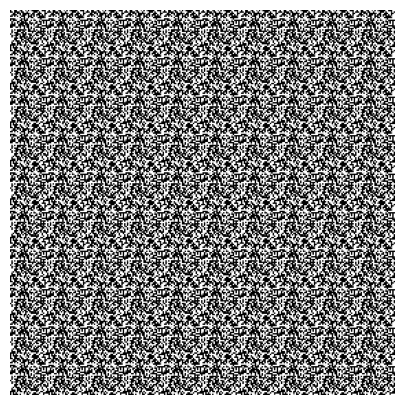

In [27]:
# GAN
#with latent vector size =64, train size=50000
latent_dim = 64
# 1= Generator
z = Input(shape=(latent_dim,))
generator = build_Generator(z)
print("Generator network")
print(generator.summary())
generated_image = generator(z)

# 2=Discrimonator
optimizer = Adam(0.0002, 0.5)
# Build and compile the discriminator
discriminator = build_Discriminator()
print("Discriminator network")
print(discriminator.summary())
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

# step 1: Only train the generator for the combined model
discriminator.trainable = False
# The discriminator takes generated image as input and determines validity
real_or_fake = discriminator(generated_image)

combined = Model(z, real_or_fake)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
train(generator, discriminator, combined, steps=5000,batch_size=100)
plot_generated_image(generator)



